### Importing Packages


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Raw Datasets

- Since the 3 datasets from MovieLens have no column headers, we use the README file as reference and create new column headers.

- After processing all individual files, concatenate all DataFrames in the list into a single DataFrame.

- Save this combined DataFrame as a new CSV file.

In [15]:
import pandas as pd
import numpy as np
import os
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from geopy.geocoders import Nominatim
from collections import Counter

# Define the column names for the ratings, users, and movies files
ratings_columns = ['reviewer_id', 'movie_id', 'reviewer_rating', 'review_timestamp']
users_columns = ['reviewer_id', 'reviewer_gender', 'reviewer_age', 'reviewer_occupation', 'reviewer_zipcode']
movie_columns = ['movie_id', 'movie_title', 'movie_genre']

# Load the ratings, users, and movies data with the proper encoding
ratings = pd.read_csv('/content/drive/My Drive/raw_datasets/ratings.dat', sep='::', names=ratings_columns, engine='python', encoding='ISO-8859-1')
users = pd.read_csv('/content/drive/My Drive/raw_datasets/users.dat', sep='::', names=users_columns, engine='python', encoding='ISO-8859-1')
movies = pd.read_csv('/content/drive/My Drive/raw_datasets/movies.dat', sep='::', names=movie_columns, engine='python', encoding='ISO-8859-1')

# Merge the dataframes: First movies with ratings, then users
movie_reviews_with_demographic = pd.merge(ratings, movies, on='movie_id')
movie_reviews_with_demographic = pd.merge(movie_reviews_with_demographic, users, on='reviewer_id')

### Feature Engineering

- Create new features using data from existing columns
  *   Extract movie_year_of_release from the movie_title
  *   Create reviewer_area by categorising reviewer_zipcode by the first digit of the zipcode

- Adjust data type of columns to ensure suitability
  *   Convert review_timestamp from Unix time to datetime format
  *   Convert movie_genre into a list of string genres

- Remove features/columns that are not useful
  *   Drop the movie_id column
  *   Drop the reviewer_zipcode column

- Additional cleaning to remove duplicates

In [16]:
# Extract the year from movie_title and create a new column 'movie_year_of_release'
movie_reviews_with_demographic['movie_year_of_release'] = movie_reviews_with_demographic['movie_title'].str.extract(r'\((\d{4})\)')

# Remove the year from the 'movie_title' column
movie_reviews_with_demographic['movie_title'] = movie_reviews_with_demographic['movie_title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()



# Define a function to extract the first digit of each zipcode and assign it as the 'reviewer_area'
def extract_reviewer_area(zipcode_list):
    # Get the first digit of the first zipcode in the list
    return int(str(zipcode_list[0])[0])

# Apply the function to the 'reviewer_zipcode' column
movie_reviews_with_demographic['reviewer_area'] = movie_reviews_with_demographic['reviewer_zipcode'].apply(extract_reviewer_area)


# Split the genre column into lists of genres
movie_reviews_with_demographic['movie_genre'] = movie_reviews_with_demographic['movie_genre'].str.split('|')



# Drop the 'reviewer_zipcode' column
movie_reviews_with_demographic = movie_reviews_with_demographic.drop('reviewer_zipcode', axis=1)

# Drop the 'movie_id' column
movie_reviews_with_demographic = movie_reviews_with_demographic.drop('movie_id', axis=1)

# Convert review_timestamp from Unix time to datetime format
movie_reviews_with_demographic['review_timestamp'] = pd.to_datetime(movie_reviews_with_demographic['review_timestamp'], unit='s')




# Convert 'movie_genre' lists to strings for duplicate checking
movie_reviews_with_demographic['movie_genre'] = movie_reviews_with_demographic['movie_genre'].apply(lambda x: str(x))

# Remove duplicates
movie_reviews_with_demographic = movie_reviews_with_demographic.drop_duplicates()

# Reset the 'movie_genre' column back to lists of integers after dropping duplicates
movie_reviews_with_demographic['movie_genre'] = movie_reviews_with_demographic['movie_genre'].apply(eval)

# Optionally, reset the index after dropping duplicates
movie_reviews_with_demographic.reset_index(drop=True, inplace=True)

desired_order = ['reviewer_id','reviewer_gender','reviewer_age','reviewer_occupation','reviewer_area','reviewer_rating','review_timestamp','movie_title','movie_genre','movie_year_of_release']
movie_reviews_with_demographic = movie_reviews_with_demographic[desired_order]


In [17]:
movie_reviews_with_demographic

,reviewer_id,reviewer_gender,reviewer_age,reviewer_occupation,reviewer_area,reviewer_rating,review_timestamp,movie_title,movie_genre,movie_year_of_release
0,1,F,1,10,4,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest,[Drama],1975
1,1,F,1,10,4,3,2000-12-31 22:35:09,James and the Giant Peach,"[Animation, Children's, Musical]",1996
2,1,F,1,10,4,3,2000-12-31 22:32:48,My Fair Lady,"[Musical, Romance]",1964
3,1,F,1,10,4,4,2000-12-31 22:04:35,Erin Brockovich,[Drama],2000
4,1,F,1,10,4,5,2001-01-06 23:38:11,"Bug's Life, A","[Animation, Children's, Comedy]",1998
...,...,...,...,...,...,...,...,...,...,...
1000204,6040,M,25,6,1,1,2000-04-26 02:35:41,Weekend at Bernie's,[Comedy],1989
1000205,6040,M,25,6,1,5,2000-04-25 23:21:27,"Crying Game, The","[Drama, Romance, War]",1992
1000206,6040,M,25,6,1,5,2000-04-25 23:19:06,Welcome to the Dollhouse,"[Comedy, Drama]",1995
1000207,6040,M,25,6,1,4,2000-04-26 02:20:48,Sophie's Choice,[Drama],1982


In [18]:
movie_reviews_with_demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   reviewer_id            1000209 non-null  int64         
 1   reviewer_gender        1000209 non-null  object        
 2   reviewer_age           1000209 non-null  int64         
 3   reviewer_occupation    1000209 non-null  int64         
 4   reviewer_area          1000209 non-null  int64         
 5   reviewer_rating        1000209 non-null  int64         
 6   review_timestamp       1000209 non-null  datetime64[ns]
 7   movie_title            1000209 non-null  object        
 8   movie_genre            1000209 non-null  object        
 9   movie_year_of_release  1000209 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 76.3+ MB


### Summary Statistics

In [19]:
print("Count of datapoints: ", movie_reviews_with_demographic.shape)
print("Count of Unique Reviewers: ", movie_reviews_with_demographic['reviewer_id'].nunique())
print("Count of Unique Movies: ", movie_reviews_with_demographic['movie_title'].nunique())

Count of datapoints:  (1000209, 10)
Count of Unique Reviewers:  6040
Count of Unique Movies:  3664


In [20]:
movie_reviews_with_demographic.describe().round(2)

,reviewer_id,reviewer_age,reviewer_occupation,reviewer_area,reviewer_rating,review_timestamp
count,1000209.00,1000209.00,1000209.00,1000209.00,1000209.00,1000209
mean,3024.51,29.74,8.04,4.99,3.58,2000-10-22 19:41:35.404665856
min,1.00,1.00,0.00,0.00,1.00,2000-04-25 23:05:32
25%,1506.00,25.00,2.00,2.00,3.00,2000-08-03 11:37:17
50%,3070.00,25.00,7.00,5.00,4.00,2000-10-31 18:46:46
75%,4476.00,35.00,14.00,9.00,4.00,2000-11-26 06:42:19
max,6040.00,56.00,20.00,9.00,5.00,2003-02-28 17:49:50
std,1728.41,11.75,6.53,3.19,1.12,NaN


### Histogram of Number of Ratings given by each Reviewer

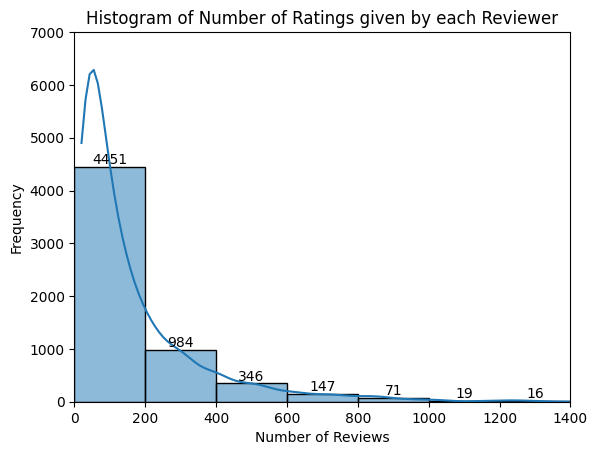

In [21]:
unique_reviewers = movie_reviews_with_demographic.groupby('reviewer_id').size().reset_index(name='Count_of_Reviews')

bin_interval = 200
bin_edges = np.arange(0, unique_reviewers['Count_of_Reviews'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=unique_reviewers, x='Count_of_Reviews', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'),
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 5),
                    textcoords = 'offset points')

plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Ratings given by each Reviewer')
plt.xlim(0, 1400)
plt.ylim(0, 7000)
plt.show()

### Create Final Preprocessed Dataset

In [22]:
# Define the file path and name for the output CSV
output_path = '/content/drive/My Drive/BT4222_Group_5_Submission/processed_datasets/movie_reviews_with_demographic_clean.csv'

# Write the merged data to a CSV file
movie_reviews_with_demographic.to_csv(output_path, index=False, encoding='ISO-8859-1')